# Incidence du syndrome grippal

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1984 et se termine avec une semaine récente.
The base data has been taken using the this link http://www.sentiweb.fr/datasets/incidence-PAY-3.csv however in order to make sure that the data and analysis will not be altered when trying to update we have loaded the data from a local file downloaded the 8th of November 2023.

In [2]:
import os
os.chdir(os.getcwd())
data_url = "../Source/20240110_incidence-PAY-3.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Nom de colonne | Libellé de colonne                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------|
| week           | Semaine calendaire (ISO 8601)                                                                                                     |
| indicator      | Code de l'indicateur de surveillance                                                                                              |
| inc            | Estimation de l'incidence de consultations en nombre de cas                                                                       |
| inc_low        | Estimation de la borne inférieure de l'IC95% du nombre de cas de consultation                                                     |
| inc_up         | Estimation de la borne supérieure de l'IC95% du nombre de cas de consultation                                                     |
| inc100         | Estimation du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants)                                   |
| inc100_low     | Estimation de la borne inférieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| inc100_up      | Estimation de la borne supérieure de l'IC95% du taux d'incidence du nombre de cas de consultation (en cas pour 100,000 habitants) |
| geo_insee      | Code de la zone géographique concernée (Code INSEE) http://www.insee.fr/fr/methodes/nomenclatures/cog/                            |
| geo_name       | Libellé de la zone géographique (ce libellé peut être modifié sans préavis)                                                       |

La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant `skiprows=1`.

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202352,3,133672,119008.0,148336.0,201,179.0,223.0,FR,France
1,202351,3,150155,137846.0,162464.0,226,207.0,245.0,FR,France
2,202350,3,147971,136787.0,159155.0,223,206.0,240.0,FR,France
3,202349,3,147552,136422.0,158682.0,222,205.0,239.0,FR,France
4,202348,3,124204,113479.0,134929.0,187,171.0,203.0,FR,France
...,...,...,...,...,...,...,...,...,...,...
2039,198448,3,78620,60634.0,96606.0,143,110.0,176.0,FR,France
2040,198447,3,72029,54274.0,89784.0,131,99.0,163.0,FR,France
2041,198446,3,87330,67686.0,106974.0,159,123.0,195.0,FR,France
2042,198445,3,135223,101414.0,169032.0,246,184.0,308.0,FR,France


Y a-t-il des points manquants dans ce jeux de données ? Oui, la semaine 19 de l'année 1989 n'a pas de valeurs associées.

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
1807,198919,3,-,NaN,NaN,-,NaN,NaN,FR,France


Nous éliminons ce point, ce qui n'a pas d'impact fort sur notre analyse qui est assez simple.

In [5]:
data = raw_data.dropna().copy()
data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202352,3,133672,119008.0,148336.0,201,179.0,223.0,FR,France
1,202351,3,150155,137846.0,162464.0,226,207.0,245.0,FR,France
2,202350,3,147971,136787.0,159155.0,223,206.0,240.0,FR,France
3,202349,3,147552,136422.0,158682.0,222,205.0,239.0,FR,France
4,202348,3,124204,113479.0,134929.0,187,171.0,203.0,FR,France
...,...,...,...,...,...,...,...,...,...,...
2039,198448,3,78620,60634.0,96606.0,143,110.0,176.0,FR,France
2040,198447,3,72029,54274.0,89784.0,131,99.0,163.0,FR,France
2041,198446,3,87330,67686.0,106974.0,159,123.0,195.0,FR,France
2042,198445,3,135223,101414.0,169032.0,246,184.0,308.0,FR,France


Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [7]:
sorted_data = data.set_index('period').sort_index()
sorted_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
period,,,,,,,,,,
1984-10-29/1984-11-04,198444,3,68422,20056.0,116788.0,125,37.0,213.0,FR,France
1984-11-05/1984-11-11,198445,3,135223,101414.0,169032.0,246,184.0,308.0,FR,France
1984-11-12/1984-11-18,198446,3,87330,67686.0,106974.0,159,123.0,195.0,FR,France
1984-11-19/1984-11-25,198447,3,72029,54274.0,89784.0,131,99.0,163.0,FR,France
1984-11-26/1984-12-02,198448,3,78620,60634.0,96606.0,143,110.0,176.0,FR,France
...,...,...,...,...,...,...,...,...,...,...
2023-11-27/2023-12-03,202348,3,124204,113479.0,134929.0,187,171.0,203.0,FR,France
2023-12-04/2023-12-10,202349,3,147552,136422.0,158682.0,222,205.0,239.0,FR,France
2023-12-11/2023-12-17,202350,3,147971,136787.0,159155.0,223,206.0,240.0,FR,France


Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste sauf pour deux périodes consécutives
entre lesquelles il manque une semaine.

Nous reconnaissons ces dates: c'est la semaine sans observations
que nous avions supprimées !

In [8]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

1989-05-01/1989-05-07 1989-05-15/1989-05-21


Un premier regard sur les données !

In [9]:
#plt.plot(sorted_data['week'],sorted_data['inc'])
#plt.show()
#sorted_data['inc'].plot()

Un zoom sur les dernières années montre mieux la situation des pics en hiver. Le creux des incidences se trouve en été.

In [10]:
#sorted_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval
entre deux années civiles, nous définissons la période de référence
entre deux minima de l'incidence, du 1er août de l'année $N$ au
1er août de l'année $N+1$.

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er août de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er août.

Comme l'incidence de syndrome grippal est très faible en été, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent an octobre 1984, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1985.

In [11]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1985,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er août, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [12]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Voici les incidences annuelles.

In [13]:
#yearly_incidence.plot(style='*')

Une liste triée permet de plus facilement répérer les valeurs les plus élevées (à la fin).

In [14]:
yearly_incidence.sort_values()

1999    1214713082934385324913033696810837170752023524...
1998    1386208617993226184251314542323110189132921693...
2000    1478264071499757760033348191754312430285532418...
1986    1695874882261140389302152798622219276053981949...
2007    1773001572217011071786253289451195013920166732...
2002    1899900299043994663802597362540718113202411896...
1996    1946700905188724963659489513123184991624514980...
2008    1965132418933531177110014494769159851351712987...
2019    2048183919621368150632154915734971747409804877...
2001    2159140516905188559029902243741719338272374002...
1987    2247102731155762105879182159982661528665335163...
2014    2270470947401889129146395027932453719794123911...
2020    2337159215931672101022953172489770918505712277...
2012    2409259024213312417846068365140071702114053748...
1992    2464625165420992372238024297460143732674028185...
2013    2696638164923858827763847775147152025717873186...
1990    2721711479406039466147691202218296246223145343...
2016    284515

Enfin, un histogramme montre bien que les épidémies fortes, qui touchent environ 10% de la population
  française, sont assez rares: il y en eu trois au cours des 35 dernières années.

<Axes: >

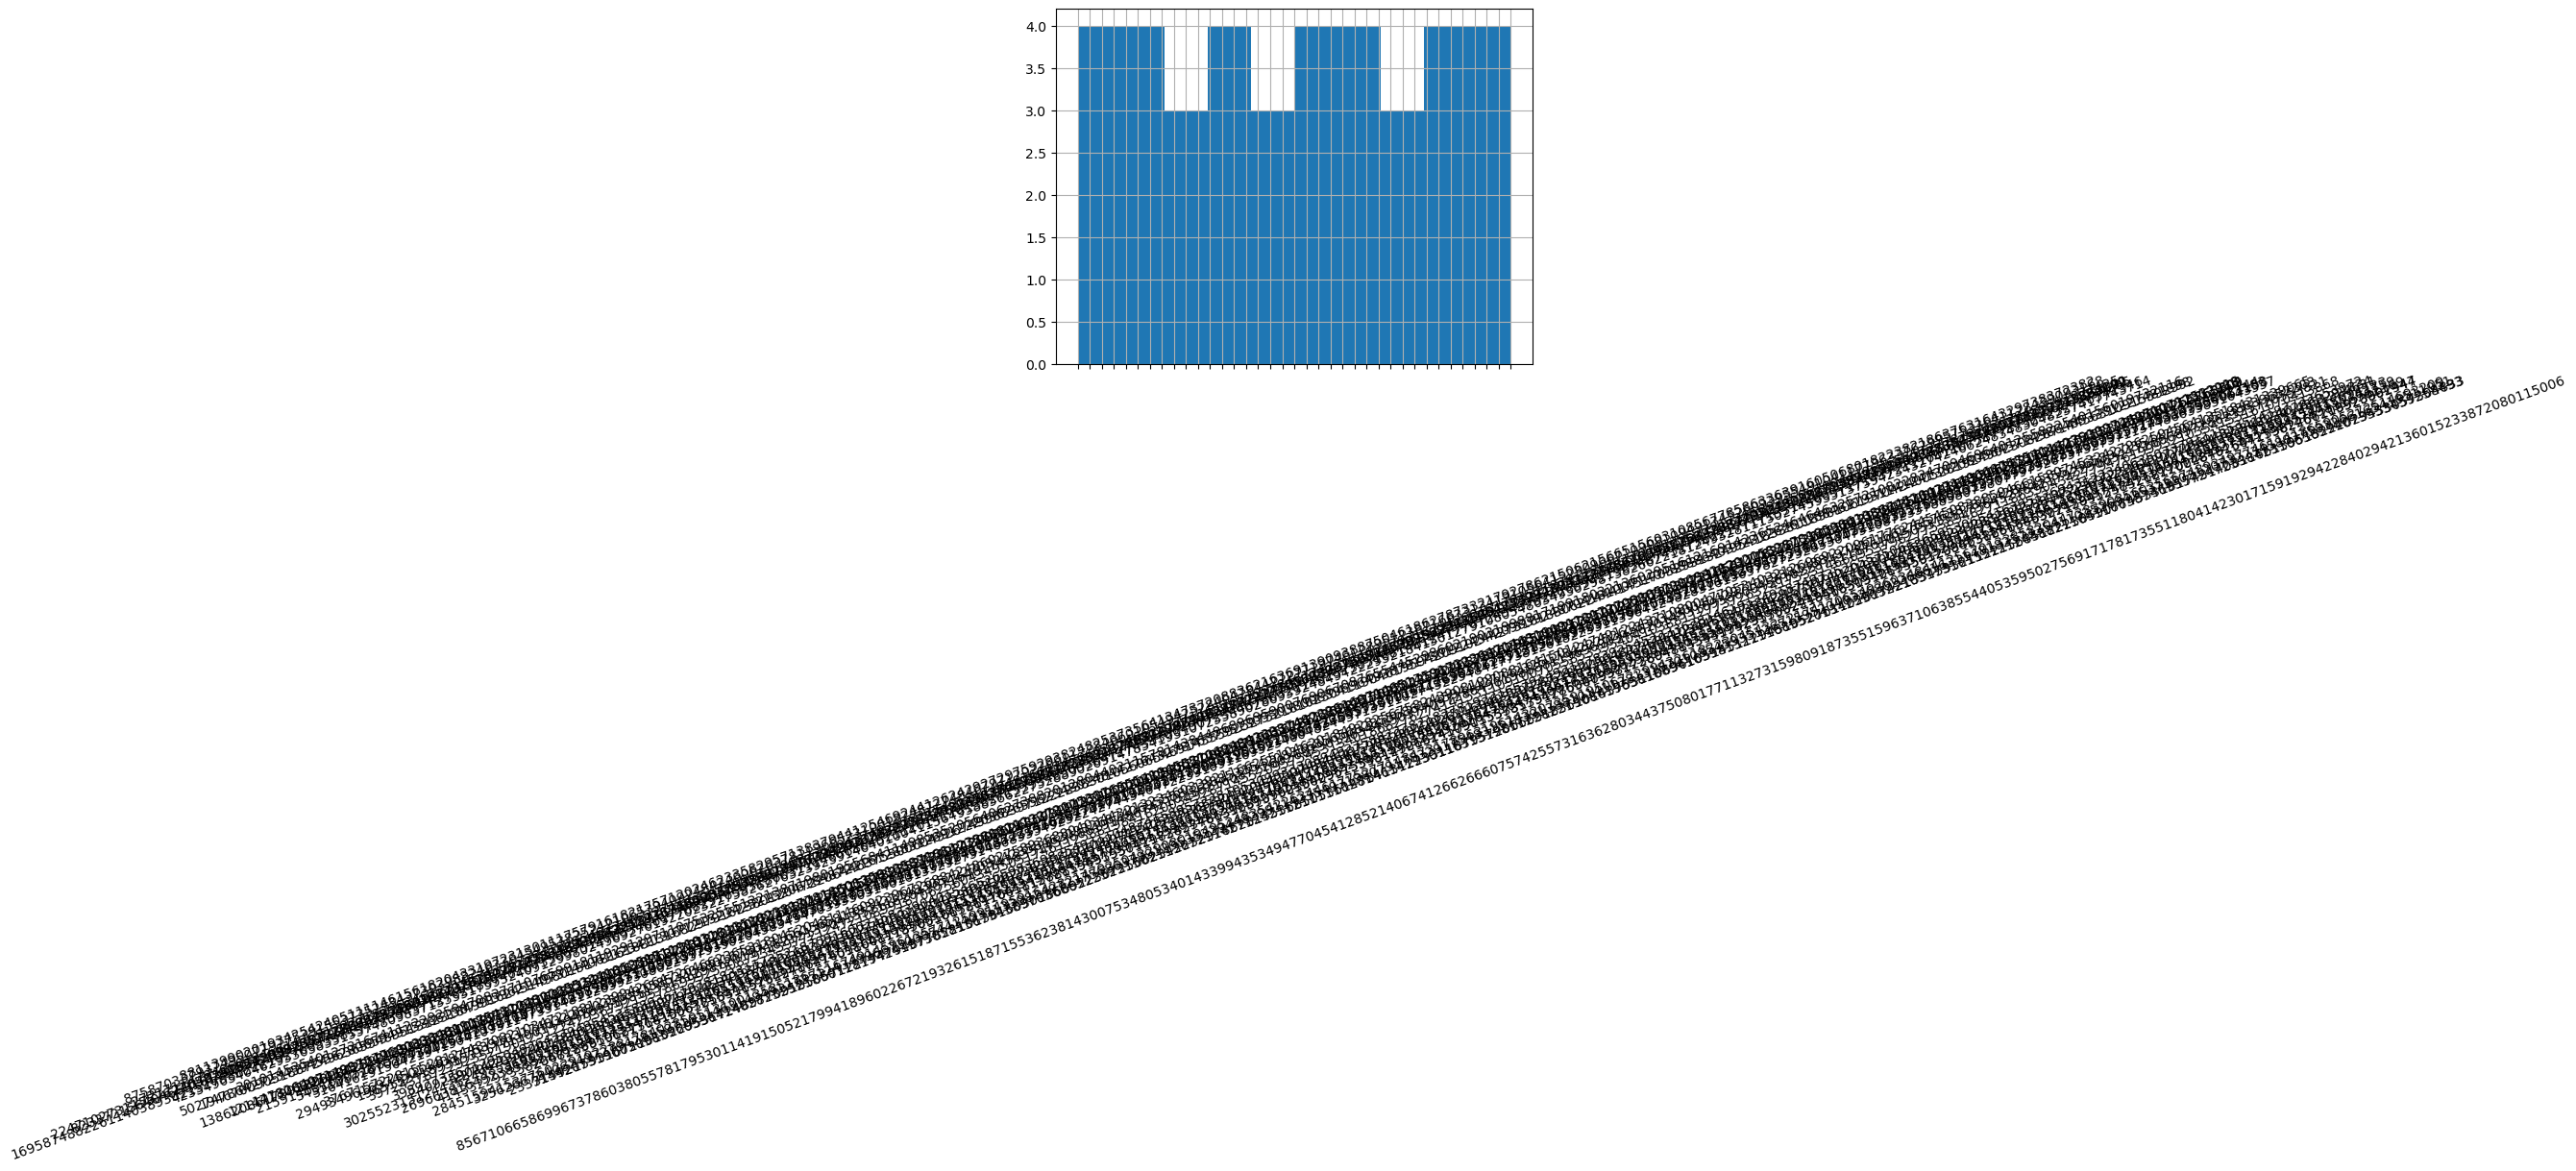

In [15]:
yearly_incidence.hist(xrot=20)